In [13]:
# Manipulation des données
import pandas as pd
import numpy as np

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Prétraitement
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Modèles
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.metrics import classification_report, roc_auc_score, ConfusionMatrixDisplay

import xgboost as xgb
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt
from scipy.stats import uniform, randint

In [18]:
# Définir le chemin des données
raw_data_path = "../data/raw/creditcard.csv"

# Charger le dataset
df = pd.read_csv(raw_data_path)

# Afficher un aperçu
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Shape: (284807, 31)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  flo

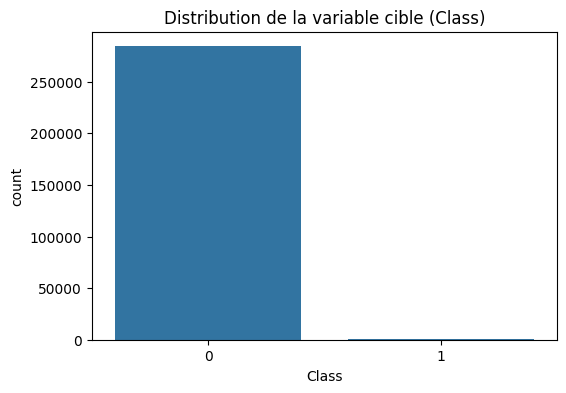

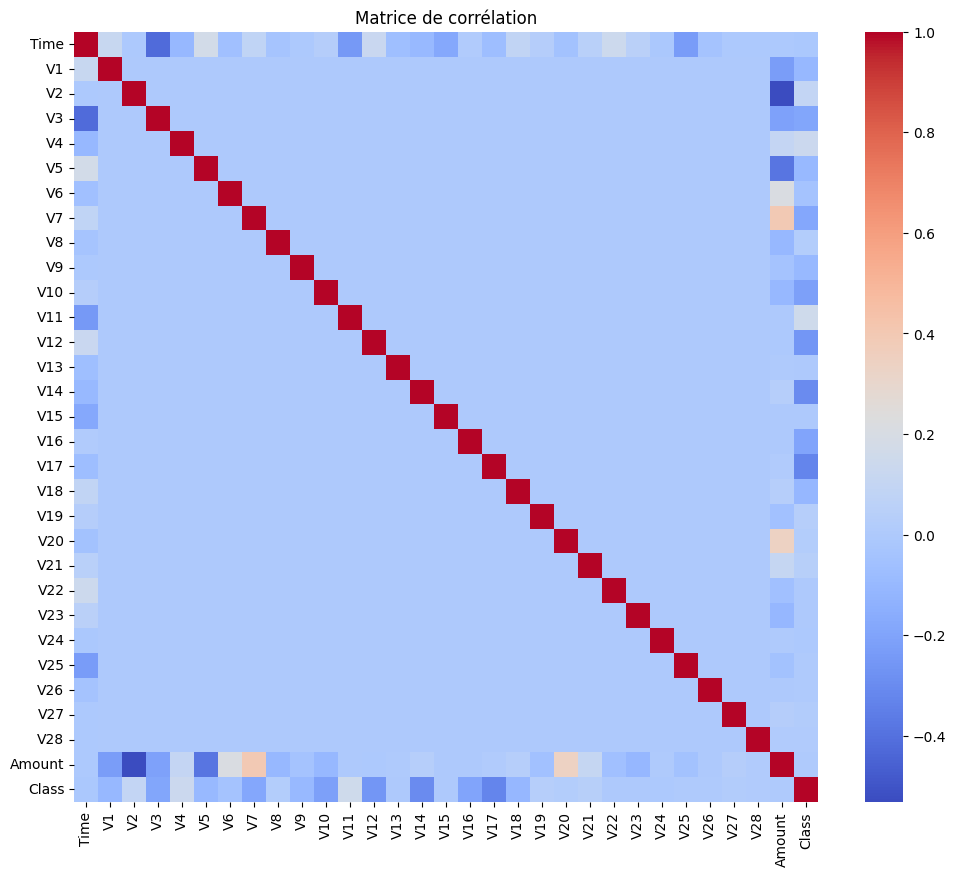

X shape: (284807, 30)
y shape: (284807,)


In [19]:
# Dimensions et aperçu
print("Shape:", df.shape)
print(df.info())
print(df.describe())

# Vérifier les valeurs manquantes
print(df.isnull().sum())

# Distribution de la variable cible
plt.figure(figsize=(6,4))
sns.countplot(x='Class', data=df)
plt.title("Distribution de la variable cible (Class)")
plt.show()

# Corrélation entre variables
plt.figure(figsize=(12,10))
sns.heatmap(df.corr(), cmap='coolwarm', fmt=".2f")
plt.title("Matrice de corrélation")
plt.show()

# Préparer X et y pour le modèle
X = df.drop('Class', axis=1)
y = df['Class']

print("X shape:", X.shape)
print("y shape:", y.shape)


In [20]:
# Séparer features et cible
X = df.drop('Class', axis=1)
y = df['Class']

# Train/test split (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Standardiser les colonnes Time et Amount
scaler = StandardScaler()
X_train[['Time','Amount']] = scaler.fit_transform(X_train[['Time','Amount']])
X_test[['Time','Amount']] = scaler.transform(X_test[['Time','Amount']])

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train distribution:\n", y_train.value_counts())


X_train shape: (227845, 30)
X_test shape: (56962, 30)
y_train distribution:
 Class
0    227451
1       394
Name: count, dtype: int64


In [26]:
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from tqdm import tqdm
import numpy as np

# Paramètres à tester
param_list = [
    {'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 0.8},
    {'max_depth': 4, 'learning_rate': 0.05, 'subsample': 0.9, 'colsample_bytree': 0.9},
]

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

best_score = 0
best_params = None

for i, params in enumerate(tqdm(param_list, desc="RandomizedSearchCV", ncols=100)):
    model = xgb.XGBClassifier(
        objective='binary:logistic',
        eval_metric='auc',
        n_jobs=-1,
        random_state=42,
        n_estimators=500,
        **params
    )
    
    scores = []
    for train_idx, val_idx in cv.split(X_train, y_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], verbose=0)  # sans early_stopping

        y_pred = model.predict(X_val)
        scores.append(f1_score(y_val, y_pred))
    
    mean_score = np.mean(scores)
    if mean_score > best_score:
        best_score = mean_score
        best_params = params

    if (i+1) % 10 == 0:
        print(f"Iteration {i+1}/{len(param_list)}, best F1 so far: {best_score:.4f}")

print("Meilleurs paramètres :", best_params)
print("Meilleur F1 CV :", best_score)

# Fit final avec le meilleur paramètre
final_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    n_jobs=-1,
    random_state=42,
    n_estimators=500,
    **best_params
)

final_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=0)


RandomizedSearchCV:   0%|                                                     | 0/2 [00:00<?, ?it/s]C:\Users\33767\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:18:43] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\33767\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:18:52] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\33767\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:19:02] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
RandomizedSearchCV:  50%|██████████████

Meilleurs paramètres : {'max_depth': 4, 'learning_rate': 0.05, 'subsample': 0.9, 'colsample_bytree': 0.9}
Meilleur F1 CV : 0.863830457750217


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=500,
              n_jobs=-1, num_parallel_tree=None, ...)